In [2]:
cd ~/bench

/home/soda/rcappuzz/work/benchmark-join-suggestions


In [3]:
%load_ext autoreload
%autoreload 2

In [36]:
from joblib import load
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import polars as pl
from src.utils.joining import execute_join_with_aggregation
import polars as pl
import numpy as np
import datetime
from src.utils.plotting import LABEL_MAPPING
import src.utils.plotting as plotting
from src.utils.logging import read_logs


In [5]:
sns.set_context("talk")

In [6]:
DEFAULT_QUERY_RESULT_DIR = Path("results/query_results")

In [7]:
def load_query_result(yadl_version, index_name, tab_name, query_column, top_k):
    query_result_path = "{}__{}__{}__{}.pickle".format(
        yadl_version,
        index_name,
        tab_name,
        query_column,
    )

    with open(Path(DEFAULT_QUERY_RESULT_DIR, query_result_path), "rb") as fp:
        query_result = pickle.load(fp)

    query_result.select_top_k(top_k)
    return query_result

# Studying the query results on their own

Results are prepared with the script `analysis_query_results.py`.


In [8]:
df = pl.read_csv("analysis_query_results.csv")

In [9]:
df.head()

retrieval_method,data_lake_version,table_name,query_column,aggregation,top_k,rank,cnd_table,cnd_column,containment,src_nrows,src_ncols,cnd_nrows,cnd_ncols,join_time
str,str,str,str,str,i64,i64,str,str,f64,i64,i64,i64,i64,f64
"""exact_matching…","""wordnet_full""","""company_employ…","""col_to_embed""","""first""",30,0,"""20d3c463551bdf…","""wordnet_compan…",0.778519,3109,2,72866,19,0.019849
"""exact_matching…","""wordnet_full""","""company_employ…","""col_to_embed""","""first""",30,1,"""bb07025128e446…","""wordnet_compan…",0.761508,3109,2,60066,3,0.014955
"""exact_matching…","""wordnet_full""","""company_employ…","""col_to_embed""","""first""",30,2,"""6aa1967be2d074…","""wordnet_compan…",0.749166,3109,2,68877,3,0.014295
"""exact_matching…","""wordnet_full""","""company_employ…","""col_to_embed""","""first""",30,3,"""3d1c4969f30b40…","""wordnet_compan…",0.749166,3109,2,60677,3,0.013742
"""exact_matching…","""wordnet_full""","""company_employ…","""col_to_embed""","""first""",30,4,"""5643654a04617e…","""wordnet_compan…",0.713809,3109,2,56891,3,0.012783


In [10]:
df = df.with_columns(
    (pl.col("cnd_nrows") * pl.col("containment")).alias("matched_rows")
)

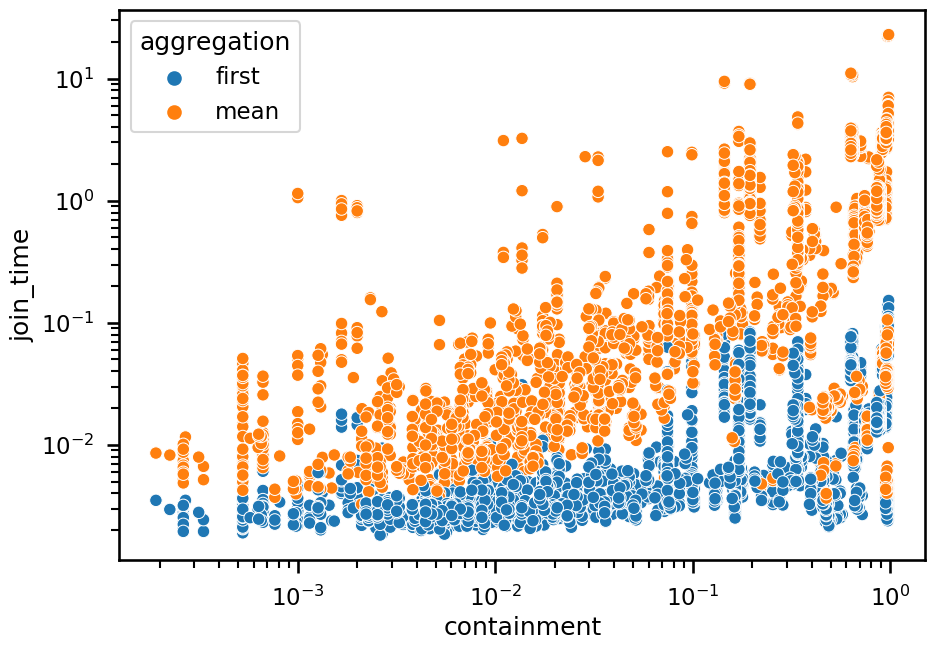

In [11]:
ax = sns.scatterplot(data=df.filter(pl.col("top_k") == 200).to_pandas(), x="containment", y="join_time", hue="aggregation")
ax.set_yscale("log")
ax.set_xscale("log")

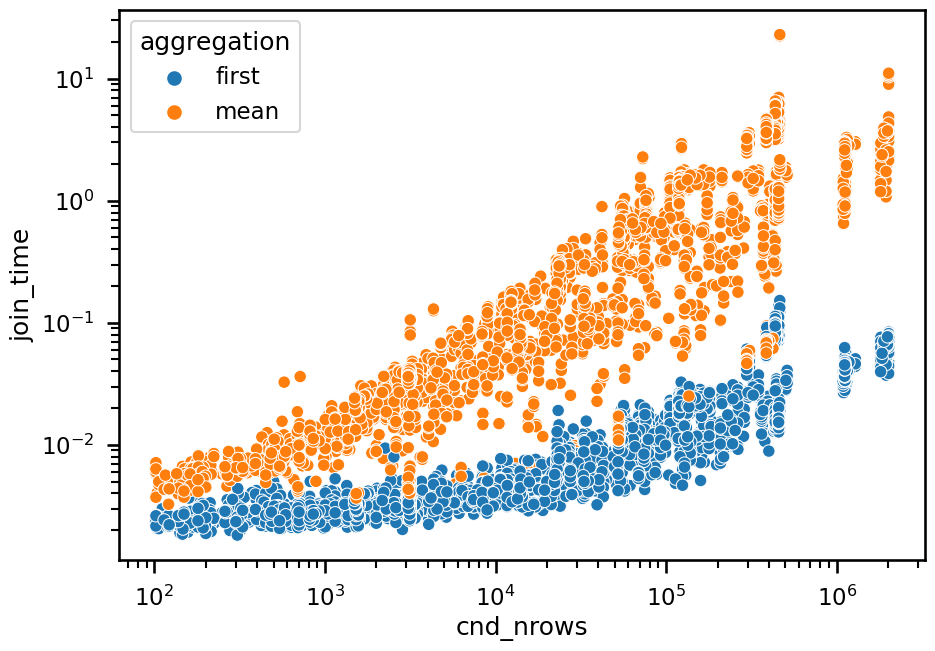

In [12]:
ax = sns.scatterplot(data=df.filter(pl.col("top_k") == 200).to_pandas(), x="cnd_nrows", y="join_time", hue="aggregation")
ax.set_yscale("log")
ax.set_xscale("log")

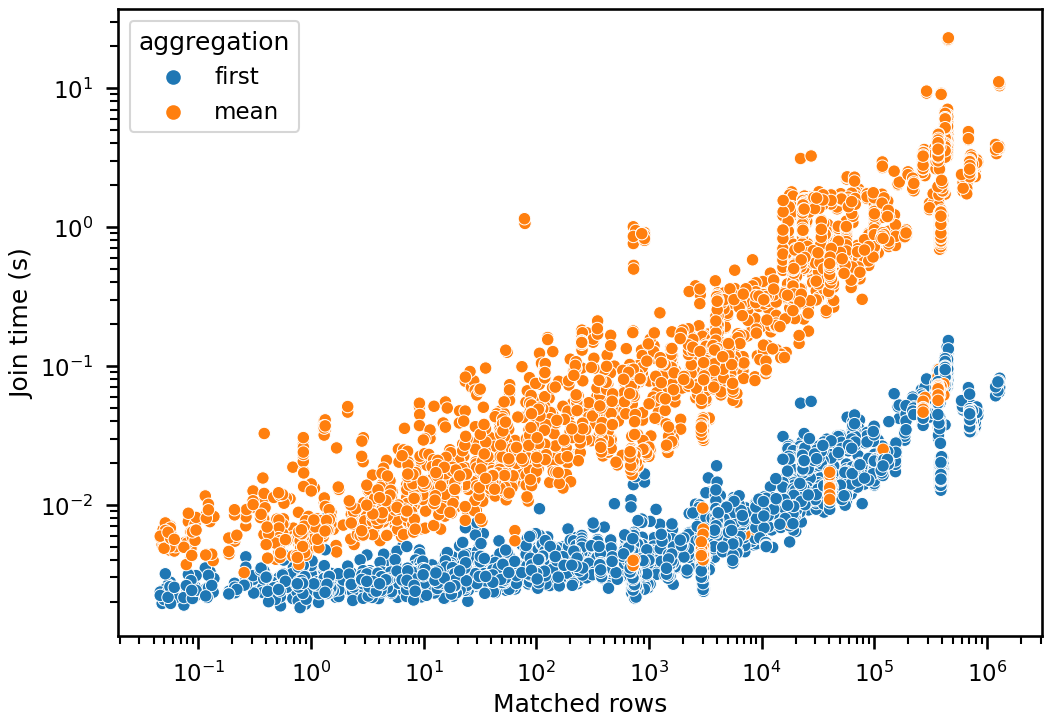

In [13]:
x_axis_var = "matched_rows"
fig, ax = plt.subplots(squeeze=True, layout="constrained")
sns.scatterplot(data=df.filter(pl.col("top_k") == 200).to_pandas(), x=x_axis_var, y="join_time", hue="aggregation", ax=ax)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Matched rows")
ax.set_ylabel("Join time (s)")
fig.savefig(f"images/join_time-{x_axis_var}.pdf")

In [14]:
LABEL_MAPPING["jd_method"]

{'exact_matching': 'Exact',
 'minhash': 'MinHash',
 'minhash_hybrid': 'Hybrid MinHash'}

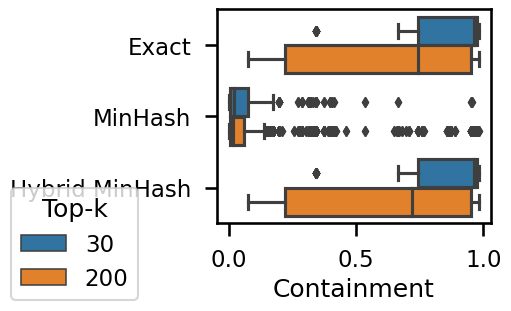

In [15]:
fig, ax = plt.subplots(squeeze=True, figsize=(5,3), layout="constrained")
sns.boxplot(data=df.to_pandas(), x="containment", y="retrieval_method", hue="top_k", ax=ax)
ax.get_legend().remove()
fig.legend(loc="lower left", title="Top-k")
ax.set_yticklabels([LABEL_MAPPING["jd_method"][x.get_text()] for x in ax.get_yticklabels()])
ax.set_xlabel("Containment")
ax.set_ylabel("")
fig.savefig("images/containment-topk.pdf")
fig.savefig("images/containment-topk.png")

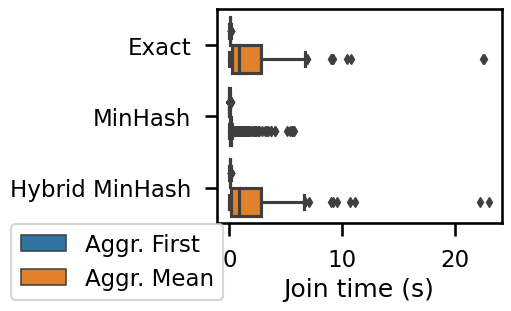

In [16]:
fig, ax = plt.subplots(squeeze=True, figsize=(5,3), layout="constrained")
sns.boxplot(data=df.filter(pl.col("top_k") == 200).to_pandas(), x="join_time", y="retrieval_method", hue="aggregation", ax=ax)
h, l = ax.get_legend_handles_labels()
mp = {
    "first": "Aggr. First",
    "mean": "Aggr. Mean",
    }
l = [mp[_] for _ in l]
ax.get_legend().remove()
fig.legend(h, l, loc="lower left")
ax.set_yticklabels([LABEL_MAPPING["jd_method"][x.get_text()] for x in ax.get_yticklabels()])
ax.set_xlabel("Join time (s)")
ax.set_ylabel("")
fig.savefig("images/join_time-topk.pdf")
fig.savefig("images/join_time-topk.png")

In [17]:
df_agg = df.group_by(
    ["retrieval_method", "data_lake_version", "table_name", "query_column", "aggregation", "top_k"]
).agg(
    pl.col("containment").mean().alias("avg_containment"),
    pl.col("containment").median().alias("median_containment"),
    pl.col("cnd_nrows").mean().alias("avg_cnd_nrows"),
    pl.col("cnd_nrows").median().alias("median_cnd_nrows"),
    pl.col("join_time").mean().alias("avg_join_time"),
    pl.col("join_time").median().alias("median_join_time"),
).sort("retrieval_method", "table_name")

In [18]:
df_agg

retrieval_method,data_lake_version,table_name,query_column,aggregation,top_k,avg_containment,median_containment,avg_cnd_nrows,median_cnd_nrows,avg_join_time,median_join_time
str,str,str,str,str,i64,f64,f64,f64,f64,f64,f64
"""exact_matching…","""wordnet_full""","""company_employ…","""col_to_embed""","""first""",200,0.322091,0.217645,125087.67,38712.5,0.013408,0.0096325
"""exact_matching…","""wordnet_full""","""company_employ…","""col_to_embed""","""mean""",30,0.688848,0.679453,52925.633333,54943.5,0.638988,0.625542
"""exact_matching…","""wordnet_full""","""company_employ…","""col_to_embed""","""first""",30,0.688848,0.679453,52925.633333,54943.5,0.012468,0.0127795
"""exact_matching…","""wordnet_full""","""company_employ…","""col_to_embed""","""mean""",200,0.322091,0.217645,125087.67,38712.5,0.612195,0.300624
"""exact_matching…","""wordnet_full""","""housing_prices…","""col_to_embed""","""mean""",30,0.970825,0.970678,454688.833333,456020.0,5.376627,4.7626005
"""exact_matching…","""wordnet_full""","""housing_prices…","""col_to_embed""","""mean""",200,0.95021,0.953045,390344.99,385997.5,3.319431,3.720989
"""exact_matching…","""wordnet_full""","""housing_prices…","""col_to_embed""","""first""",200,0.95021,0.953045,390344.99,385997.5,0.071236,0.0658955
"""exact_matching…","""wordnet_full""","""housing_prices…","""col_to_embed""","""first""",30,0.970825,0.970678,454688.833333,456020.0,0.088402,0.0859365
"""exact_matching…","""wordnet_full""","""movies-yadl-de…","""col_to_embed""","""mean""",200,0.303648,0.195045,222211.235,95385.5,0.865886,0.6554965


In [19]:
df.write_csv("results_indexing_time_cont.csv")

In [20]:
ddf=df_agg.melt(
    id_vars=["retrieval_method", "aggregation", "top_k"],value_vars=["median_containment", "avg_join_time"]
)

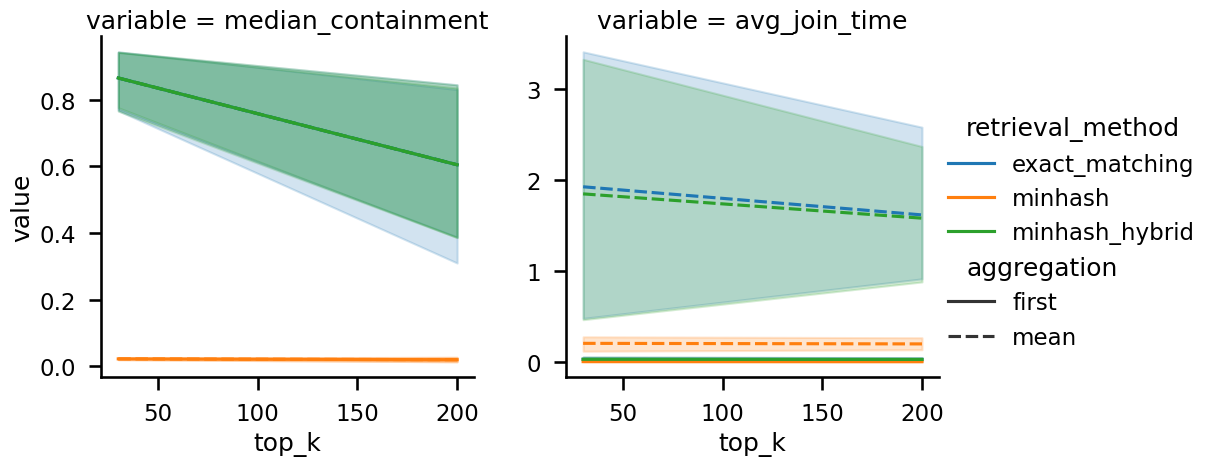

In [21]:
sns.relplot(data=ddf, x="top_k", y="value", hue="retrieval_method", col="variable", kind="line", facet_kws={"sharey":False}, style='aggregation')

# Joining the query results with the general results

In [22]:
# full run, aggr. first
df_1 = read_logs(exp_name="0354-m76sawxd", exp_path=None)
# full run, aggr. mean
df_2 = read_logs(exp_name="0348-1bne8cxm", exp_path=None)
df_raw = pl.concat([df_1, df_2]).fill_null(0)


In [23]:
# exp_name = "0360-jinwugcl"
exp_path = "results/logs/0363-mp1a3by4"
df_raw = read_logs(exp_name=None, exp_path=exp_path)
df_raw = df_raw.filter(pl.col("estimator") != "nojoin")

In [24]:
df_raw.unique("estimator")

scenario_id,status,target_dl,jd_method,base_table,query_column,estimator,aggregation,chosen_model,fold_id,time_fit,time_predict,time_run,time_prepare,time_model_train,time_join_train,time_model_predict,time_join_predict,peak_fit,peak_predict,peak_test,r2score,rmse,f1score,auc,n_cols,budget_type,budget_amount,epsilon
i64,str,str,str,str,str,str,str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,i64,f64
0,"""SUCCESS""","""wordnet_full""","""exact_matching…","""us_elections-y…","""col_to_embed""","""stepwise_greed…","""first""","""linear""",0,23.834725,0.231836,24.105321,4.464837,18.748198,0.627293,0.103564,0.088396,417.09375,405.9375,403.238281,0.023116,1.245154,null,null,null,"""iterations""",30,0.0
0,"""SUCCESS""","""wordnet_full""","""exact_matching…","""us_elections-y…","""col_to_embed""","""highest_contai…","""first""","""linear""",0,1.13538,0.116697,1.2809,0.628497,0.431858,0.020513,0.066098,0.022509,404.8125,408.074219,408.074219,0.061398,1.220513,null,null,null,null,null,null
0,"""SUCCESS""","""wordnet_full""","""exact_matching…","""us_elections-y…","""col_to_embed""","""best_single_jo…","""first""","""linear""",0,6.567271,0.077161,6.669088,0.006964,4.451434,2.032026,0.024637,0.022242,421.945312,404.070312,404.070312,0.000957,1.259198,null,null,null,null,null,null
0,"""SUCCESS""","""wordnet_full""","""exact_matching…","""us_elections-y…","""col_to_embed""","""full_join""","""first""","""linear""",0,2.52915,0.451949,3.02574,0.004276,2.26971,0.207063,0.202598,0.212576,471.582031,445.101562,434.632812,0.040136,1.234259,null,null,null,null,null,null


In [25]:
df_agg = df.filter(pl.col("top_k") == 200).group_by(
    ["retrieval_method", "data_lake_version", "table_name", "query_column", "aggregation"]
).agg(
    pl.col("containment").mean().alias("avg_containment"),
    pl.col("containment").median().alias("median_containment"),
    pl.col("containment").top_k(30).mean().alias("top_30_avg_containment"),
    pl.col("containment").top_k(30).median().alias("top_30_median_containment"),
    pl.col("cnd_nrows").mean().alias("avg_cnd_nrows"),
    pl.col("cnd_nrows").median().alias("median_cnd_nrows"),
    pl.col("join_time").mean().alias("avg_join_time"),
    pl.col("join_time").median().alias("median_join_time"),
    pl.col("matched_rows").mean().alias("avg_matched_rows"),
    pl.col("matched_rows").median().alias("median_matched_rows"),
).sort("retrieval_method", "table_name")

In [26]:
res=df_raw.join(df_agg, left_on=["target_dl", "jd_method", "base_table", "query_column"], right_on=["data_lake_version", "retrieval_method", "table_name", "query_column"])

In [27]:
f = {"jd_method": "exact_matching", "chosen_model": "catboost"}

<Axes: xlabel='avg_containment', ylabel='r2score'>

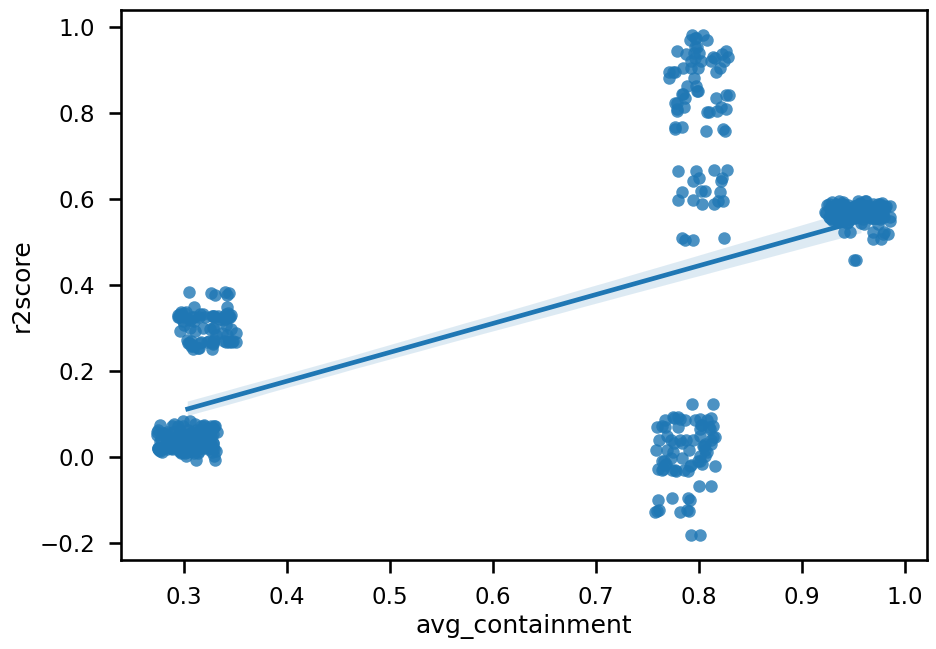

In [28]:
sns.regplot(data=res.filter(**f).to_pandas(), x="avg_containment", y="r2score",  x_jitter=0.03)

[Text(0, 0, '(D) US Elections'),
 Text(0, 1, '(D) Housing Prices'),
 Text(0, 2, '(D) Employees'),
 Text(0, 3, '(D) Movies'),
 Text(0, 4, '(D) Movies Vote'),
 Text(0, 5, '(D) US Accidents'),
 Text(0, 6, '(D) US County Population')]

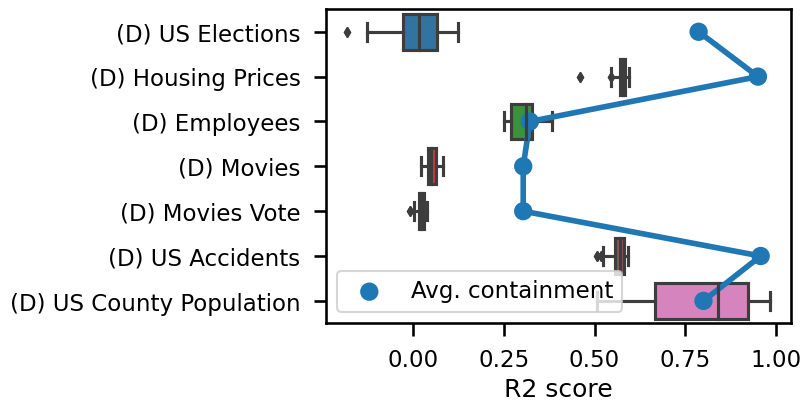

In [29]:
fig, ax = plt.subplots(figsize=(8, 4), layout="constrained")
_d = res.filter(**f).select(["base_table", "r2score"]).melt(id_vars=["base_table"])
sns.boxplot(data=_d.to_pandas(), y="base_table", x="value",ax=ax)
_d = res.filter(**f).select(["base_table", "avg_containment"]).melt(id_vars=["base_table"])
# ax2 = ax.twiny()
sns.pointplot(data=_d.to_pandas(), y="base_table", x="value",ax=ax, label="Avg. containment")
ax.legend(loc="lower left")
ax.set_xlabel("R2 score")
ax.set_ylabel(None)
ax.set_yticklabels([LABEL_MAPPING["base_table"][x.get_text()] for x in ax.get_yticklabels()])

[Text(0, 0, '(D) US Elections'),
 Text(0, 1, '(D) Housing Prices'),
 Text(0, 2, '(D) Employees'),
 Text(0, 3, '(D) Movies'),
 Text(0, 4, '(D) Movies Vote'),
 Text(0, 5, '(D) US Accidents'),
 Text(0, 6, '(D) US County Population')]

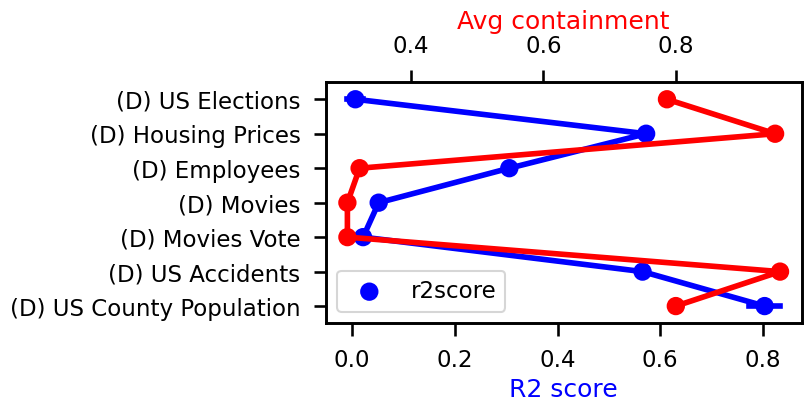

In [30]:
fig, ax = plt.subplots(figsize=(8, 4), layout="constrained")
_d = res.filter(**f).select(["base_table", "r2score"]).melt(id_vars=["base_table"])
sns.pointplot(data=_d.to_pandas(), y="base_table", x="value",ax=ax, label="r2score", color="blue")
_d = res.filter(**f).select(["base_table", "avg_containment"]).melt(id_vars=["base_table"])
ax2 = ax.twiny()
sns.pointplot(data=_d.to_pandas(), y="base_table", x="value",ax=ax2, label="Avg. containment", color="red")
ax.legend(loc="lower left")
ax.set_xlabel("R2 score", color="blue")
ax2.set_xlabel("Avg containment", color="red")
ax.set_ylabel(None)
ax.set_yticklabels([LABEL_MAPPING["base_table"][x.get_text()] for x in ax.get_yticklabels()])

[Text(0, 0, '(D) US Elections'),
 Text(0, 1, '(D) Housing Prices'),
 Text(0, 2, '(D) Employees'),
 Text(0, 3, '(D) Movies'),
 Text(0, 4, '(D) Movies Vote'),
 Text(0, 5, '(D) US Accidents'),
 Text(0, 6, '(D) US County Population')]

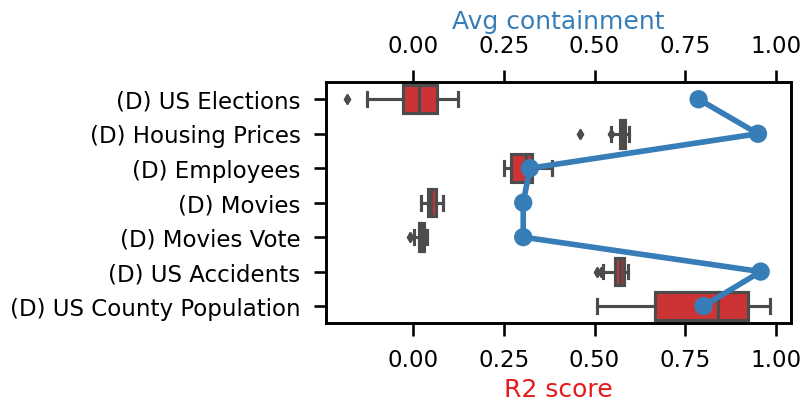

In [37]:
cmap = mpl.colormaps["Set1"](range(2))
fig, ax = plt.subplots(figsize=(8, 4), layout="constrained")
_d = res.filter(**f).select(["base_table", "r2score"]).melt(id_vars=["base_table"])
sns.boxplot(data=_d.to_pandas(), y="base_table", x="value",ax=ax, color=cmap[0])
_d = res.filter(**f).select(["base_table", "avg_containment"]).melt(id_vars=["base_table"])
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
sns.pointplot(data=_d.to_pandas(), y="base_table", x="value",ax=ax2, label="Avg. containment", color=cmap[1])
# ax.legend(loc="lower left")
ax.set_xlabel("R2 score", color=cmap[0])
# ax2.legend(loc="lower left")
ax2.set_xlabel("Avg containment", color=cmap[1])
ax.set_ylabel(None)
ax.set_yticklabels([LABEL_MAPPING["base_table"][x.get_text()] for x in ax.get_yticklabels()])

In [32]:
res.select(
    pl.corr("r2score", "avg_containment").alias("corr_avg_containment"),
    pl.corr("r2score", "median_containment").alias("corr_median_containment"),
    pl.corr("r2score", "median_cnd_nrows").alias("corr_median_cnd_nrows"),
    pl.corr("r2score", "median_matched_rows").alias("corr_median_matched_rows"),
    pl.corr("r2score", "top_30_avg_containment").alias("corr_top_30_avg_containment"),
    pl.corr("r2score", "top_30_median_containment").alias("corr_top_30_median_containment"),
).transpose(include_header=True).sort("column_0").write_csv("corr.csv")

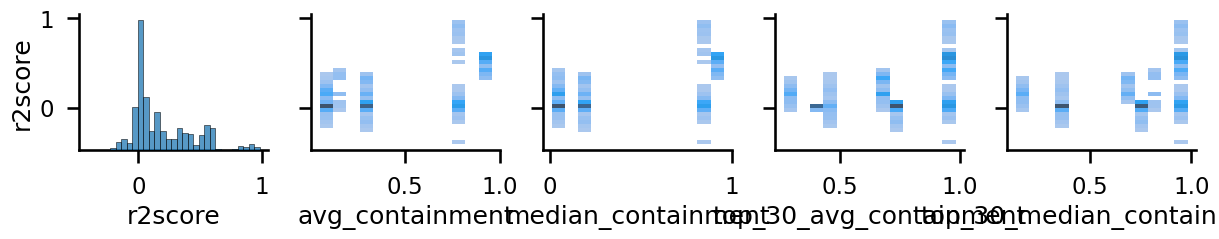

In [33]:
_d = res.select(
    pl.col("r2score"),
    pl.col("avg_containment"),
    pl.col("median_containment"),
    # pl.col("median_cnd_nrows"),
    # pl.col("median_matched_rows"),
    pl.col("top_30_avg_containment"),
    pl.col("top_30_median_containment"),
)

sns.pairplot(data=_d.to_pandas(), y_vars="r2score", kind="hist")

<Axes: xlabel='time_run', ylabel='aggregation'>

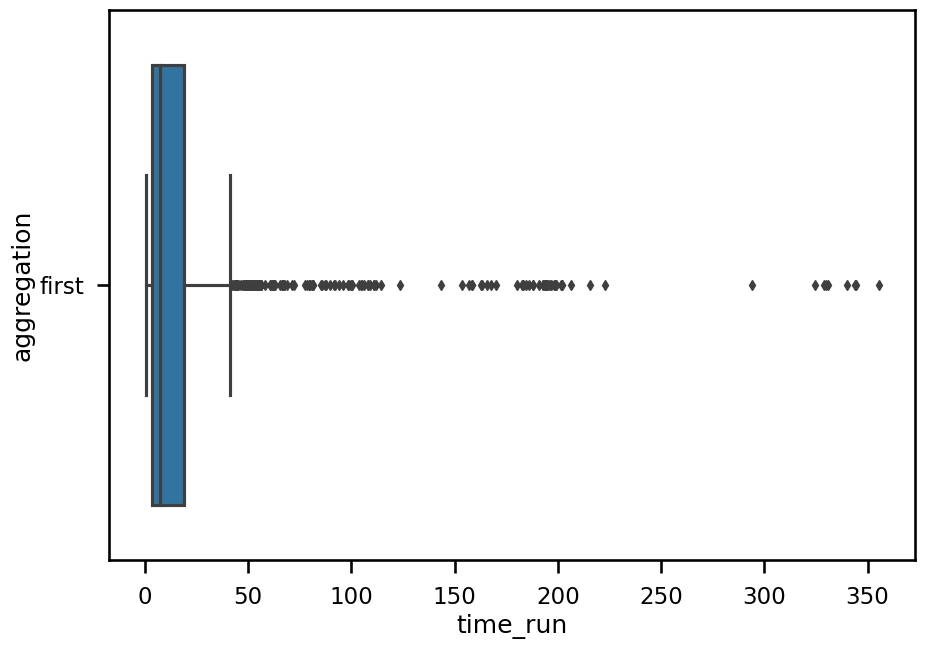

In [34]:
sns.boxplot(data=df_raw.to_pandas(), x="time_run", y="aggregation")